## Summary 

Author: Trenton Bricken

Learning a projection matrix for CIFAR and MNIST datasets. Uses Pytorch and has built in GPU compatibility to accelerate training. 

In [1]:
%load_ext autoreload
%autoreload 2
from Implementations_Associative_Memory import *
from Data_Processing_Associative_Memory import *
from utils_LearnProjections import *
from SDM_Circ_Inter_Funcs import *
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch.nn.functional as F
import copy
from types import SimpleNamespace
torch.cuda.set_device(0) 

Device is: cuda
Files already downloaded and verified
Files already downloaded and verified
Train and Test sets Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           ) Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


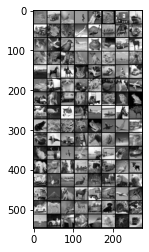

torch.Size([10000, 1, 32, 32])


[0, 50, 100, 150, 200, 250, 300]

In [2]:
data_name = "CIFAR" #"MNIST" # "CIFAR"
load_in_W_k = True
learn_beta = False
n_train_repeats = 3 # number of weight matrices trained from random initialization for each parameter setting.
n_perturb_repeats = 1 # number of times perturbations are applied to the same learned weight matrix.
if learn_beta:
    neuron_vals = [None]
else: 
    neuron_vals = list(np.round(np.logspace(6,20,5))) # testing the algorithms with different numbers of neurons
    neuron_vals.append(None)
hamm_radii = [5, 9, 11, 15] 
max_perturb = 300
n_perturbs = 7 #number of perturbations to apply. 
cont_circle_intersect = False # fitting beta to binary SDM during training using the Attention softmax

m=None #None means to use the full database. 
batch_size = 128
n=64
r = 2**n
tbatch_size = 5000
num_workers = 4
print_each_result = False 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is:", device)
algorithms = ['Cont_Binary_SDM_NeuronLimit']#["Cont_SDM_NeuronLimit", "Cont_Binary_SDM_NeuronLimit", "Cont_SDM_BFit_Attention", "Cont_SDM_CFit_Attention"] 
train_test_iter = [True, False] # evaluates trained projection matrices on train and test datasets
rad = 1 # circle radius size. Unit norm here. 

# None values are placeholders. 
sdm_params = dict(
    n=n, 
    n_base = None, # used as the base dimension, 
    r=r, 
    m=m,
    batch_size = batch_size,
    hamm_radius =None,
    fix_perturb=None,
    proj_epochs = 10, # number of epochs to train weight matrix. 10 gives good convergence.
    lr=0.005,
    max_conv_steps = 10, # steps to update the query
    epsilon = 0.05, # removes any rounding error in computing the similarity.
    ensure_no_closer_images = False,
    min_train_perturb = 10,
    max_train_perturb = 100,
    perturb=None,
    device=device,
    cont_cache_resolution = 10000, # number of points to use when computing the continuous circle intersection
    plot_batches = None, # plots losses during training more often
    plot_epochs = False,
    binary_data = False, # only using continuous vectors here.
    renorm_cont_queries = False, # only want to L2 norm after projecting, not on the raw images that are non L2 normed.
    train_multiple_steps = False, # allow for multiple steps during training. 
    # that have changed by less than epsilon at any of their pixel locations
    learn_beta = learn_beta
)
sdm_params = SimpleNamespace(**sdm_params) # enabling use of dot notation on the dictionary

# Generating datasets
if data_name=="MNIST":
    image_len = 28
    transform = transforms.Compose(
            [transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    
    
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transform)

elif data_name=="CIFAR":
    image_len = 32
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
        ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
print("Train and Test sets",trainset, testset)
loader_size_train = len(trainset) if m is None else m
loader_size_test = len(testset) if m is None else m
trainloader = torch.utils.data.DataLoader(trainset, batch_size=loader_size_train,
                                      shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=loader_size_test,
                                      shuffle=True, num_workers=num_workers)
# full image dimensionality, different from n=64 in the latent space projected into.
n_base = image_len**2
sdm_params.n_base = n_base

# set the loaders to give only batches. 
# somewhat hacky as using the loader from before to serve the whole dataset. 
dataiter = iter(trainloader)
keys, labels = dataiter.next()
nchannels = keys.shape[1]
# show example images:
imshow(torchvision.utils.make_grid(keys[:batch_size].view(batch_size, nchannels, image_len, image_len)))
cpu_keys = keys.flatten(start_dim=1)
trainloader = torch.utils.data.DataLoader(cpu_keys, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
keys = torch.clone(cpu_keys).to(device).T

# setting up test loader
dataiter = iter(testloader)
tkeys, labels = dataiter.next()
print(tkeys.shape)
cpu_tkeys = tkeys.flatten(start_dim=1)
testloader = torch.utils.data.DataLoader(cpu_tkeys, batch_size=tbatch_size,
                                         shuffle=True, num_workers=num_workers)
tkeys = torch.clone(cpu_keys).to(device).T

perturb_hamms = list(np.unique(np.linspace(0,max_perturb,n_perturbs).astype(int)))
perturb_hamms

In [ ]:
"""
Iterate through hamming distances. For n_train_repeats train the projection matrix. 
Then iterate through the different algorithms to compare them. 
"""

neuron_res_nrepeats = {k:[] for k in neuron_vals}
hamm_res_nrepeats = {k:copy.deepcopy(neuron_res_nrepeats) for k in hamm_radii}
all_res = {k:copy.deepcopy(hamm_res_nrepeats) for k in algorithms}

for hamm_radius in hamm_radii:
    print('hamm_radius is', hamm_radius)
    sdm_params.hamm_radius = hamm_radius
    # varying r doesnt matter for this beta fit. For now fitting to the binary SDM beta value!
    if not learn_beta: 
        beta = fit_beta(sdm_params.n, sdm_params.r, sdm_params.hamm_radius, False, plot=False)

    for train_rep_ind in range(n_train_repeats):
        # reset W_k!
        W_k = torch.randn((n,n_base), requires_grad=True, device=device)
        if learn_beta:
            beta = torch.nn.Parameter(torch.Tensor(np.random.uniform(1,30, 1)).to(device), requires_grad=True)
            beta_name = 'trained_weights/trained_beta'+data_name+"|m="+str(m)+'|'+str(hamm_radius)+'|'+str(train_rep_ind)+'.torch'
        
        sdm_params.fix_perturb=False
        W_k_name = 'trained_weights/trained_W_k'+data_name+"|m="+str(m)+'|'+str(hamm_radius)+'|'+str(train_rep_ind)+'.torch'
        if load_in_W_k:
            W_k = torch.load(W_k_name).to(device)
            if learn_beta:
                beta = torch.load(beta_name).to(device)
        else: 
            trained_params = train_projection(W_k, sdm_params, trainloader, keys, beta)
            if learn_beta: 
                W_k, beta = trained_params
            else: 
                W_k = trained_params
            torch.save(W_k, W_k_name)
            torch.save(beta, beta_name)

        # testing everything.
        sdm_params.fix_perturb=True
        for pert_rep_ind in range(n_perturb_repeats):
        
            for algo in algorithms:
                print("Algo and train rep", algo, train_rep_ind)
                if "Attention" in algo:
                    cos_res = test_projection(algo, perturb_hamms, W_k, 
                                                        sdm_params, trainloader, 
                                                        testloader, keys, 
                                                        tkeys,
                                                        None, beta, plot_results=False )
                    all_res[algo][hamm_radius][neuron_vals[-1]].append(cos_res)

                else: 
                    # set the neuron value
                    for r in neuron_vals:
                        sdm_params.r=r
                        
                        b_cached_inters, log_c_cached_inters = get_binary_and_continuous_caches(n, hamm_radius, r, 
                                                                                    sdm_params.cont_cache_resolution)
                        b_cached_inters = torch.Tensor(b_cached_inters).to(device)
                        log_c_cached_inters = torch.Tensor(log_c_cached_inters.astype(float)).to(device)
                        
                        use_binary_intersect = True if "Cont_Binary_SDM" in algo else False
                        input_cache = b_cached_inters if use_binary_intersect else log_c_cached_inters
                        
                        should_continue=check_caches_work_for_num_neurons(r, hamm_radius, use_binary_intersect, b_cached_inters, log_c_cached_inters)
                        if should_continue == 'continue':
                            continue
                            
                        cos_res = test_projection(algo, perturb_hamms, W_k, 
                                                    sdm_params, trainloader, 
                                                    testloader, keys,
                                                    tkeys, input_cache, beta, plot_results=False )
                        all_res[algo][hamm_radius][r].append(cos_res)


            with open(data_name+"|m="+str(m)+"EXTRAtrain_projection_runs.pkl", 'wb') as fname: 
                pickle.dump(all_res, fname)

hamm_radius is 5
Algo and train rep Cont_Binary_SDM_NeuronLimit 0
r of 1000000.0 is too small for d radii of 5 largest intersections tensor([4.5014e-07, 6.9106e-08, 6.9106e-08, 1.2527e-08, 1.2527e-08],
       device='cuda:0')
r of 3162277660.0 is too small for d radii of 5 largest intersections tensor([1.4235e-03, 2.1853e-04, 2.1853e-04, 3.9613e-05, 3.9613e-05],
       device='cuda:0')


In [21]:
all_res.keys()

dict_keys(['Cont_SDM_NeuronLimit', 'Cont_Binary_SDM_NeuronLimit', 'Cont_SDM_BFit_Attention', 'Cont_SDM_CFit_Attention'])

In [20]:
load_all_res = True

if load_all_res:
    with open(data_name+"|m="+str(m)+"train_projection_runs.pkl", 'rb') as fname: 
        all_res = pickle.load(fname)

## Plots of all results: 

(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)


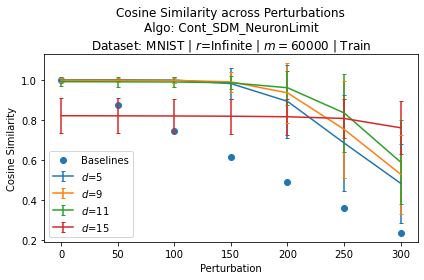

(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)


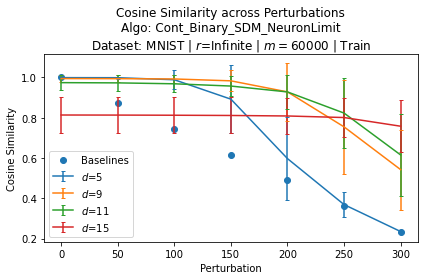

(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)


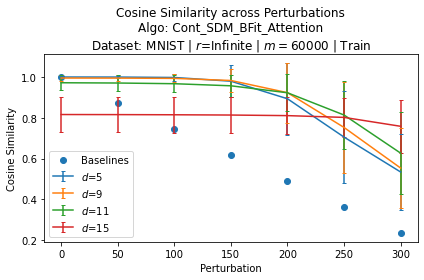

(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)
(3, 7, 60000)


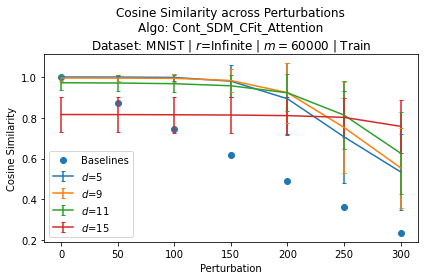

(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)


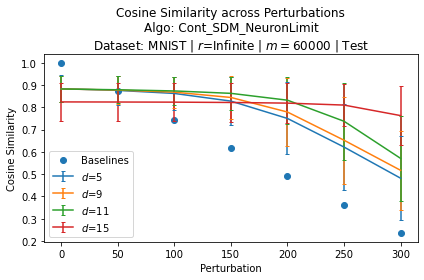

(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)


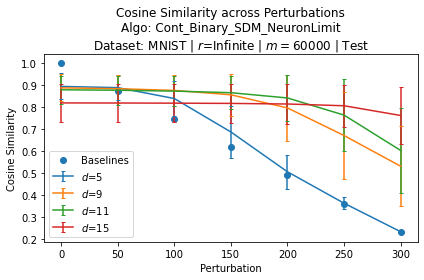

(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)


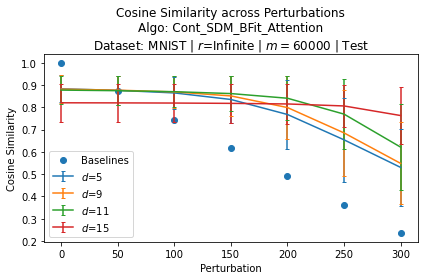

(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)
(3, 7, 10000)


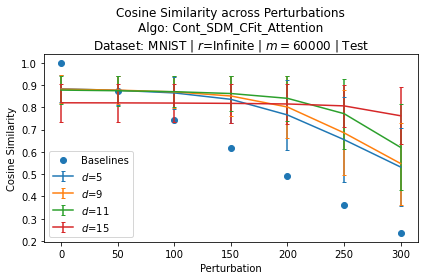

In [22]:
directory='figures/LearnProjections/'

nneurons = neuron_vals[-1]

for train in [True, False]:
    for key, res_per_key in og_all_res.items():
        # each is a dictionary i need to homogenize. 
        for hamm_radius in np.sort(hamm_radii):

            agg = []

            for res in res_per_key[hamm_radius][nneurons]:
                if train: 
                    agg.append(res['train'])
                    labl = 'Train'
                else: 
                    agg.append(res['test'])
                    labl='Test'
            agg = np.asarray(agg)
            print(agg.shape)
            iters_mu = agg.mean(axis=(0,2)) # mean for each iteration value
            iters_std = agg.std(axis=(0,2))

            #stds = np.stack([np.asarray(stds), np.zeros((len(stds)))])
            plt.errorbar(perturb_hamms, iters_mu, yerr=iters_std,capsize=2, label='$d$='+str(hamm_radius))
        
        plt.scatter(perturb_hamms, hamm_to_cosine(np.asarray(perturb_hamms),n_base), label='Baselines')
        
        if nneurons is None or nneurons == "None": 
            neuron_label = 'Infinite'
        else:
            print(float(nneurons))
            neuron_label = '$r$='+"{:.0e}".format(nneurons)
            
        if m is None: 
            printm= len(trainset)
            
        plt.title("Cosine Similarity across Perturbations"+"\n"+"Algo: "+key+"\nDataset: "+data_name+" | $r$="+neuron_label+" | $m=$"+str(printm)+" | "+labl)
        plt.legend()
        plt.xlabel("Perturbation")
        plt.ylabel("Cosine Similarity")
        save_str = "Dataset="+data_name+"|n="+str(n)+"m="+str(m)+"r="+str(r)+"Type="+key+"|NumNeuron="+neuron_label+"|"+labl
        plt.tight_layout()
        plt.gcf().savefig(directory+save_str+'.png', dpi=250)
        plt.show()


## Plots varying the number of neurons within each Hamming radius setting

skipping 5 1000000.0
skipping 5 3162277660.0
skipping 5 10000000000000.0
skipping 5 3.162277660168379e+16
5 1e+20 [0.9999966  0.90274954 0.65469176 0.63244915 0.63215154 0.63214946
 0.63215154]
1e+20
5 None [0.99999714 0.9999295  0.9983484  0.9808294  0.8923282  0.6847968
 0.48377278]


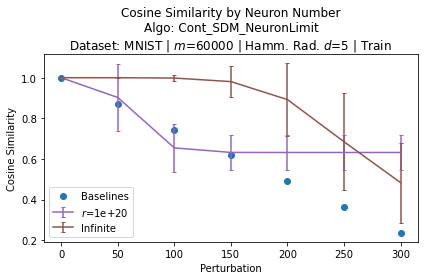

skipping 9 1000000.0
skipping 9 3162277660.0
9 10000000000000.0 [0.99784625 0.99707586 0.95431554 0.79248357 0.65455323 0.63252276
 0.6316231 ]
10000000000000.0
9 3.162277660168379e+16 [0.99785155 0.99752396 0.9968012  0.98416317 0.8977027  0.6607612
 0.48412943]
3.162277660168379e+16
9 1e+20 [0.9978547  0.99751973 0.996852   0.9893855  0.93559134 0.7524775
 0.53003186]
1e+20
9 None [0.9978521  0.9975221  0.9968611  0.9894199  0.9347162  0.75301963
 0.529     ]


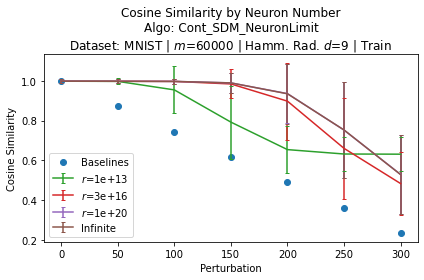

skipping 11 1000000.0
11 3162277660.0 [0.9890206  0.98630726 0.91941947 0.7373488  0.6417568  0.6231757
 0.6225776 ]
3162277660.0
11 10000000000000.0 [0.9903198  0.9896695  0.9887418  0.98465323 0.9556183  0.8093474
 0.56134194]
10000000000000.0
11 3.162277660168379e+16 [0.99032146 0.98967403 0.988733   0.9849033  0.9600505  0.8343779
 0.58941424]
3.162277660168379e+16
11 1e+20 [0.9903204  0.9896613  0.98874277 0.98482066 0.96005476 0.8347135
 0.58977515]
1e+20
11 None [0.99032056 0.9896601  0.9887319  0.9848825  0.9600828  0.83473134
 0.58925056]


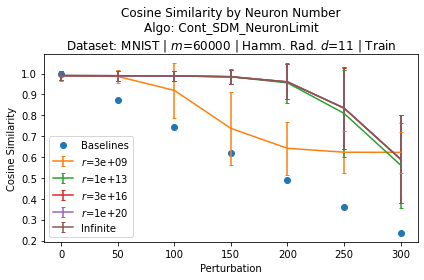

15 1000000.0 [0.8196896  0.81895345 0.8180723  0.816177   0.8111761  0.7925769
 0.70399946]
1000000.0
15 3162277660.0 [0.8206249  0.8200542  0.81938726 0.8180786  0.81542474 0.80725026
 0.760148  ]
3162277660.0
15 10000000000000.0 [0.8206249  0.8200201  0.8193601  0.8181012  0.8154555  0.80705345
 0.76007164]
10000000000000.0
15 3.162277660168379e+16 [0.82062507 0.82004434 0.81935894 0.81812376 0.81543237 0.80717456
 0.7604375 ]
3.162277660168379e+16
15 1e+20 [0.820625   0.82006675 0.8193748  0.8181229  0.8155064  0.80719364
 0.75996804]
1e+20
15 None [0.820625   0.8200472  0.8193036  0.8181861  0.8154371  0.80708826
 0.7605204 ]


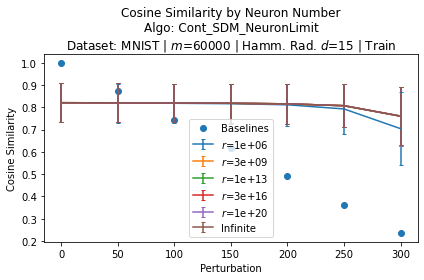

skipping 5 1000000.0
skipping 5 3162277660.0
5 10000000000000.0 [0.9999986  0.87250346 0.74489784 0.61734676 0.4897958  0.36224496
 0.23469394]
10000000000000.0
5 3.162277660168379e+16 [0.9991494  0.9987241  0.97132266 0.791371   0.5128327  0.36258778
 0.23469394]
3.162277660168379e+16
5 1e+20 [0.99913716 0.99877954 0.988426   0.892157   0.5967818  0.3687641
 0.23483285]
1e+20
5 None [0.99914086 0.99878454 0.9886506  0.8922133  0.59702075 0.36878252
 0.2348286 ]


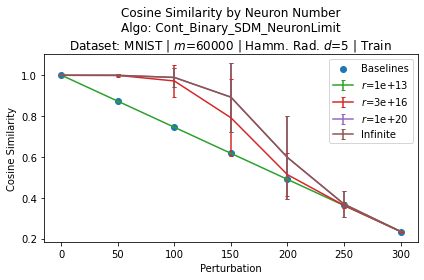

skipping 9 1000000.0
9 3162277660.0 [0.99976563 0.96740043 0.7579489  0.6173744  0.4897958  0.36224496
 0.23469394]
3162277660.0
9 10000000000000.0 [0.9945075  0.99411744 0.9928258  0.9807558  0.89185625 0.5961808
 0.29281312]
10000000000000.0
9 3.162277660168379e+16 [0.9944375  0.9940217  0.9925175  0.98310214 0.9281295  0.7547515
 0.542566  ]
3.162277660168379e+16
9 1e+20 [0.9944391  0.99404496 0.99252194 0.98289174 0.9280079  0.75393116
 0.5416744 ]
1e+20
9 None [0.9944431  0.9940149  0.9925147  0.98323643 0.928247   0.75466734
 0.5423434 ]


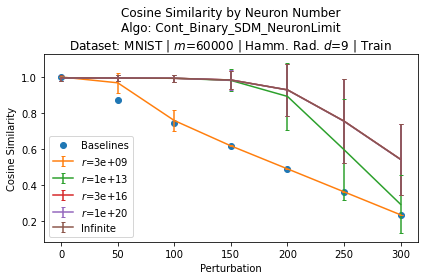

skipping 11 1000000.0
11 3162277660.0 [0.98563784 0.98523724 0.9842613  0.9516601  0.73535305 0.394844
 0.23499882]
3162277660.0
11 10000000000000.0 [0.97430164 0.9731092  0.9687584  0.9575768  0.9283731  0.8230934
 0.6128844 ]
10000000000000.0
11 3.162277660168379e+16 [0.97426486 0.9730977  0.9686659  0.95744175 0.92818254 0.82331824
 0.61479306]
3.162277660168379e+16
11 1e+20 [0.97426474 0.97310454 0.96860427 0.9573658  0.92794186 0.82247233
 0.6147611 ]
1e+20
11 None [0.9742649  0.97311074 0.96856606 0.95731544 0.9281611  0.8231119
 0.6152181 ]


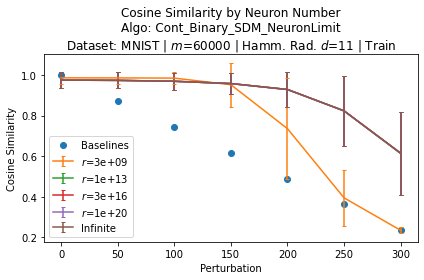

15 1000000.0 [0.85158956 0.8512761  0.8506763  0.8505856  0.812919   0.4794708
 0.23682636]
1000000.0
15 3162277660.0 [0.8135151  0.8131461  0.81244034 0.81129676 0.80865145 0.80090123
 0.7581553 ]
3162277660.0
15 10000000000000.0 [0.81353873 0.81319755 0.81245685 0.8112781  0.8087295  0.80082023
 0.7581294 ]
10000000000000.0
15 3.162277660168379e+16 [0.8135433  0.81317276 0.81245184 0.81127787 0.80872315 0.8008303
 0.7576994 ]
3.162277660168379e+16
15 1e+20 [0.813541   0.81316894 0.81242234 0.8113344  0.8087031  0.80092055
 0.7579536 ]
1e+20
15 None [0.8135453  0.81315833 0.81242657 0.8112372  0.8087178  0.8009958
 0.7578809 ]


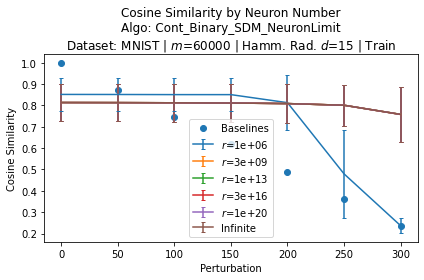

skipping 5 1000000.0
skipping 5 3162277660.0
skipping 5 10000000000000.0
skipping 5 3.162277660168379e+16
skipping 5 1e+20
5 None [0.99955505 0.9992681  0.99728453 0.9790176  0.8930679  0.7054448
 0.53461075]


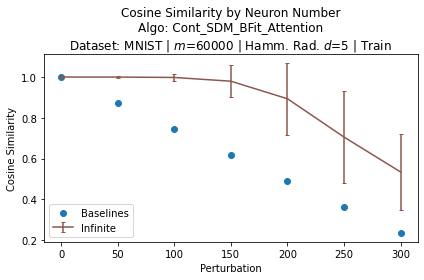

skipping 9 1000000.0
skipping 9 3162277660.0
skipping 9 10000000000000.0
skipping 9 3.162277660168379e+16
skipping 9 1e+20
9 None [0.9944862  0.9941324  0.9928459  0.98249924 0.9228426  0.75260085
 0.5539004 ]


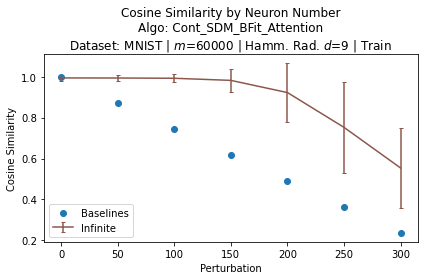

skipping 11 1000000.0
skipping 11 3162277660.0
skipping 11 10000000000000.0
skipping 11 3.162277660168379e+16
skipping 11 1e+20
11 None [0.9714201  0.9701384  0.96673733 0.95652753 0.92244446 0.81348246
 0.62692803]


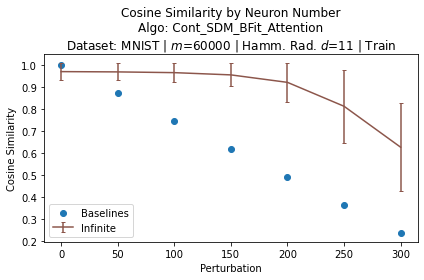

skipping 15 1000000.0
skipping 15 3162277660.0
skipping 15 10000000000000.0
skipping 15 3.162277660168379e+16
skipping 15 1e+20
15 None [0.8159185  0.8154795  0.814743   0.8134048  0.81053144 0.80188817
 0.75832796]


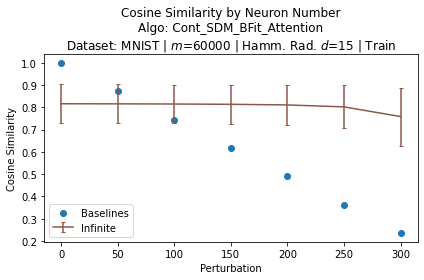

skipping 5 1000000.0
skipping 5 3162277660.0
skipping 5 10000000000000.0
skipping 5 3.162277660168379e+16
skipping 5 1e+20
5 None [0.9995503  0.99927413 0.99736726 0.9791215  0.89289534 0.7064948
 0.53508526]


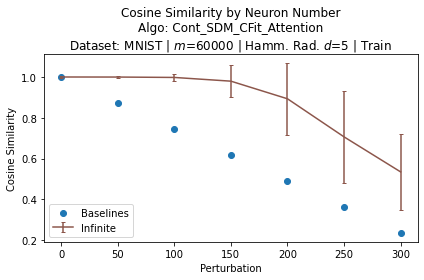

skipping 9 1000000.0
skipping 9 3162277660.0
skipping 9 10000000000000.0
skipping 9 3.162277660168379e+16
skipping 9 1e+20
9 None [0.9944859  0.9941447  0.9928757  0.9824076  0.92281413 0.7525185
 0.5550328 ]


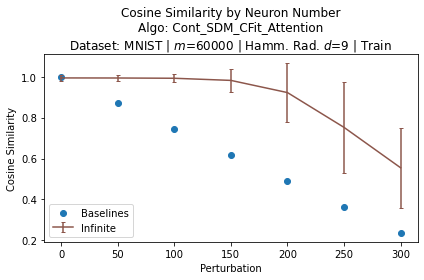

skipping 11 1000000.0
skipping 11 3162277660.0
skipping 11 10000000000000.0
skipping 11 3.162277660168379e+16
skipping 11 1e+20
11 None [0.9714201  0.97012025 0.9667218  0.95653987 0.92225975 0.81318116
 0.62646174]


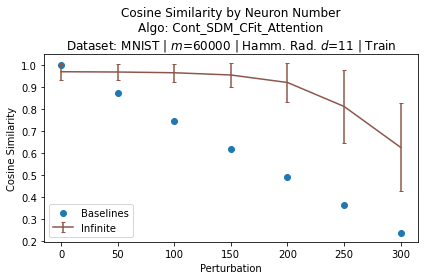

skipping 15 1000000.0
skipping 15 3162277660.0
skipping 15 10000000000000.0
skipping 15 3.162277660168379e+16
skipping 15 1e+20
15 None [0.81591374 0.81547743 0.81473446 0.81340253 0.8104733  0.8020488
 0.75806487]


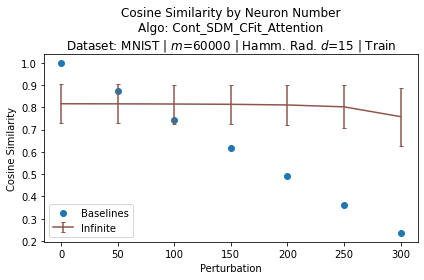

In [23]:
cmap = plt.get_cmap("tab10") # used to keep colors of each line constant across plots

for train in [True]:
    for key, res_per_key in all_res.items():
        # each is a dictionary i need to homogenize. 
        for hamm_radius in np.sort(hamm_radii):
            for nind, nneurons in enumerate(neuron_vals):
                
                if len(res_per_key[hamm_radius][nneurons])==0:
                        print("skipping", hamm_radius, nneurons)
                        continue
                agg = []
                for res in res_per_key[hamm_radius][nneurons]:
                    if train: 
                        agg.append(res['train'])
                        labl = 'Train'
                    else: 
                        agg.append(res['test'])
                        labl='Test'
                        
                agg = np.asarray(agg)

                iters_mu = agg.mean(axis=(0,2)) # mean for each iteration value
                iters_std = agg.std(axis=(0,2))

                #stds = np.stack([np.asarray(stds), np.zeros((len(stds)))])
                print(hamm_radius, nneurons, iters_mu)
                if nneurons is None or nneurons == "None": 
                    neuron_label = 'Infinite'
                else:
                    print(float(nneurons))
                    neuron_label = '$r$='+"{:.0e}".format(nneurons)
                plt.errorbar(perturb_hamms, iters_mu, color=cmap(nind), yerr=iters_std,capsize=2, label=neuron_label) 
            plt.scatter(perturb_hamms, hamm_to_cosine(np.asarray(perturb_hamms),n_base), label='Baselines')
                
            plt.title("Cosine Similarity by Neuron Number"+"\nAlgo: "+key+"\nDataset: "+data_name+" | $m$="+str(printm)+" | Hamm. Rad. $d$="+str(hamm_radius)+" | "+labl)
            plt.legend()
            plt.xlabel("Perturbation")
            plt.ylabel("Cosine Similarity")
            save_str = "NNeurons_Dataset="+data_name+"|n="+str(n)+"m="+str(m)+"Type="+key+"|NumNeuron="+neuron_label+"|d="+str(hamm_radius)+"|"+labl
            plt.tight_layout()
            plt.gcf().savefig(directory+save_str+'.png', dpi=250)
            plt.show()


In [13]:
agg.shape

(3, 7, 60000)

## Display convergence and perturbations: 

In [17]:
sdm_params

namespace(n=64,
          n_base=784,
          r=None,
          m=None,
          batch_size=2000,
          hamm_radius=5,
          fix_perturb=True,
          proj_epochs=10,
          lr=0.005,
          max_conv_steps=10,
          epsilon=0.05,
          ensure_no_closer_images=False,
          min_train_perturb=10,
          max_train_perturb=100,
          perturb=0,
          device=device(type='cuda'),
          beta=10.110419065799585,
          cont_cache_resolution=10000,
          plot_batches=None,
          plot_epochs=False,
          binary_data=False,
          renorm_cont_queries=False,
          train_multiple_steps=False)

In [13]:
# baselines for the percentage reconstructed:

sdm_params.fix_perturb = True
algorithms = ['Cont_Binary_SDM_NeuronLimit', 
              "Cont_SDM_NeuronLimit",  
              "Cont_SDM_BFit_Attention", 
              "Cont_SDM_CFit_Attention"]

load_in_W_k=True
hamm_radius=5
train_rep_ind=1
r=None#neuron_vals[-1]
train_o_test = 'test' # Test
# todo enable the test loader to work here
curr_loader = trainloader if train_o_test=='train' else testloader
keys_to_use = keys if train_o_test=='train' else tkeys
sdm_params.batch_size = batch_size if train_o_test=='train' else tbatch_size
nimages = 1
sdm_params.binary_data = False
binary_data = False

sdm_params.hamm_radius = hamm_radius
sdm_params.r = r

if load_in_W_k:
    W_k_name = 'trained_weights/trained_W_k'+data_name+"|m="+str(m)+'|'+str(hamm_radius)+'|'+str(train_rep_ind)+'.torch'
    print("load name is:", W_k_name)
    W_k = torch.load(W_k_name).to(device)

for batch_ind, queries in enumerate(curr_loader): 
    queries = queries.to(device).T
    targets = torch.clone(queries)
    norm_targets = targets/torch.norm(targets, dim=0,keepdim=True)
    break 
     
all_p_queries = None
with torch.no_grad():
    pKs = W_k@keys_to_use
    pKs = pKs/torch.norm(pKs, dim=0,keepdim=True)
    # set the neuron value
    sdm_params.r=r
    #print('=======================',r)
    # compute the caches
    b_cached_inters, log_c_cached_inters = get_binary_and_continuous_caches(n, hamm_radius, r, 
                                                                                    sdm_params.cont_cache_resolution)
    b_cached_inters = torch.Tensor(b_cached_inters).to(device)
    log_c_cached_inters = torch.Tensor(log_c_cached_inters.astype(float)).to(device)
                        
    print(hamm_to_cosine(np.asarray(perturb_hamms),n_base))
    
    for perturb in perturb_hamms:

        sdm_params.perturb = perturb
        perturbed_queries, isclosests = cosine_perturb_queries(queries, keys_to_use, sdm_params)
        
        for algo_ind, algo in enumerate(algorithms):
            
            use_binary_intersect = True if binary_data else False
            if "Cont_Binary_SDM" in algo:
                use_binary_intersect = True # overrriding this. 
            input_cache = b_cached_inters if use_binary_intersect else log_c_cached_inters

            if "Attention" in algo:
                if "CFit" in algo:
                    cont_circle_intersect = True
                elif "BFit" in algo: 
                    cont_circle_intersect = False
                else: 
                    raise Exception("Attention but neither B or C fit in the Attention function name.")
                beta = fit_beta(sdm_params.n, 2**64, sdm_params.hamm_radius, cont_circle_intersect, plot=False)
            else: 
                beta = None
        
            to_converge = torch.clone(perturbed_queries)
            
            '''plt.imshow(perturbed_queries[:,:nimages].cpu().numpy().reshape(28,28))
            plt.title("perturbed")
            plt.show()
            
            plt.imshow(to_converge[:,:nimages].cpu().numpy().reshape(28,28))
            plt.title("Input into convergence")
            plt.show()'''
            
            #print(beta, input_cache, algo)
            
            converged_queries = torch_run_algo(algo, sdm_params, to_converge, pKs, keys_to_use,
                                                                 input_cache, beta, W_k=W_k)
            
            
            
            '''plt.imshow(converged_queries[:,:nimages].cpu().numpy().reshape(28,28))
            plt.title('convergece')
            plt.show()'''
            
            print(algo, perturb, 'with target', torch_cosine_sims(converged_queries[:,:nimages] , targets[:,:nimages] ), 
                  'with perturb', torch_cosine_sims(converged_queries[:,:nimages] , perturbed_queries[:,:nimages] ) )
            
            
            if all_p_queries is None:
                all_p_queries = perturbed_queries[:,:nimages].unsqueeze(0).cpu()
            elif algo_ind==0:
                all_p_queries = torch.cat( [all_p_queries, perturbed_queries[:,:nimages].unsqueeze(0).cpu()])

            all_p_queries = torch.cat( [all_p_queries, converged_queries[:,:nimages].unsqueeze(0).cpu()])

print( all_p_queries.shape )
all_p_queries = torch.transpose(all_p_queries,  1,2).flatten(end_dim=-2)

load name is: trained_weights/trained_W_kCIFAR|m=None|5|1.torch
[1.         0.90234375 0.8046875  0.70703125 0.609375   0.51171875
 0.4140625 ]
Cont_Binary_SDM_NeuronLimit 0 with target [1.] with perturb [1.]
Cont_SDM_NeuronLimit 0 with target [0.866176] with perturb [0.866176]
Cont_SDM_BFit_Attention 0 with target [0.86579] with perturb [0.86579]
Cont_SDM_CFit_Attention 0 with target [0.866181] with perturb [0.866181]
Cont_Binary_SDM_NeuronLimit 50 with target [0.90234375] with perturb [1.]
Cont_SDM_NeuronLimit 50 with target [0.866176] with perturb [0.7756239]
Cont_SDM_BFit_Attention 50 with target [0.86465645] with perturb [0.77704096]
Cont_SDM_CFit_Attention 50 with target [0.86619866] with perturb [0.7756463]
Cont_Binary_SDM_NeuronLimit 100 with target [0.8046875] with perturb [1.]
Cont_SDM_NeuronLimit 100 with target [0.8793796] with perturb [0.7144911]
Cont_SDM_BFit_Attention 100 with target [0.9225693] with perturb [0.7445927]
Cont_SDM_CFit_Attention 100 with target [0.8793796]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


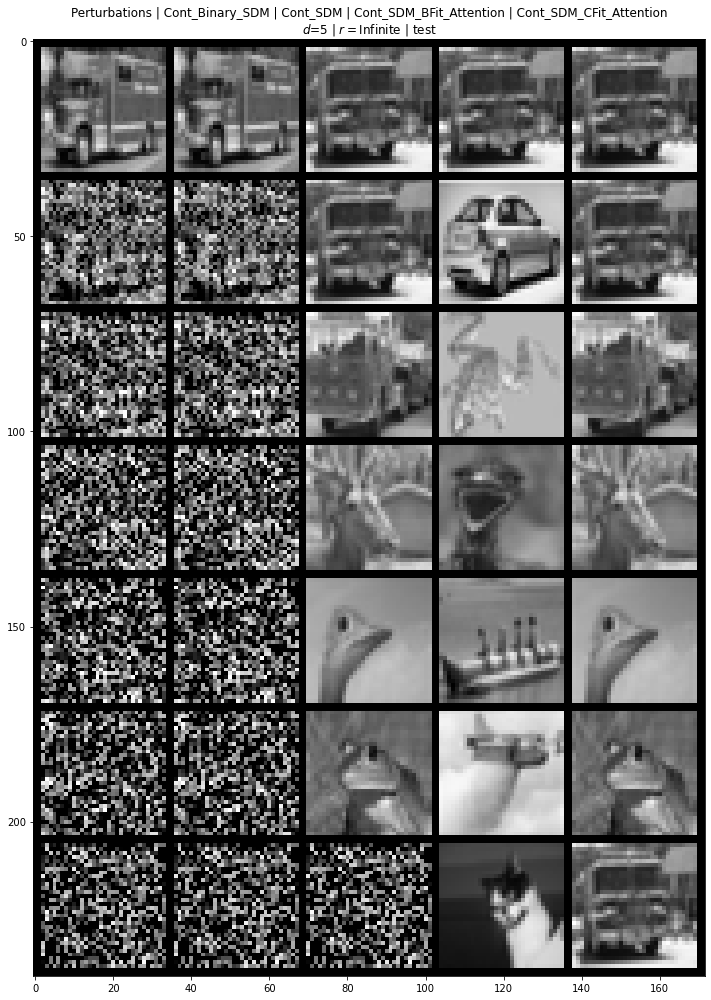

In [14]:
fig = plt.gcf()
fig.set_size_inches(18.5, 14)
randn = np.round(np.random.rand(1)*10000).astype(int)[0]
    
imshow(torchvision.utils.make_grid(all_p_queries.view(all_p_queries.shape[0], nchannels,image_len,image_len),
                                   nrow=nimages*5), show_now=False)
plt.title("Perturbations | Cont_Binary_SDM | Cont_SDM | Cont_SDM_BFit_Attention | Cont_SDM_CFit_Attention\n$d$="+str(hamm_radius)+" | $r=$Infinite | "+train_o_test)
#plt.ylabel("Increasing Perturbations")
plt.tight_layout()
fig.savefig('figures/'+data_name+train_o_test+str(randn)+'Convergences.png', dpi=100)
plt.show()

## Misc. evaluation of the images learnt, not used in the paper.

torch.Size([128, 784])
perc recon 0.9272959183673469
num agree spots 727 784


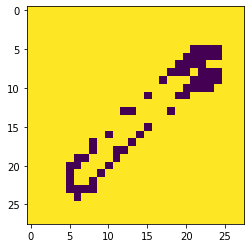

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


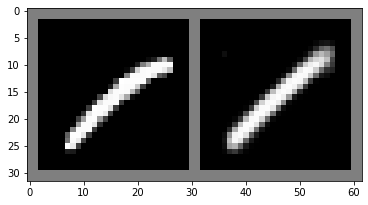

perc recon 0.9987244897959183
num agree spots 783 784


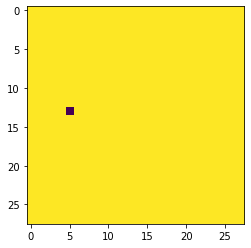

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


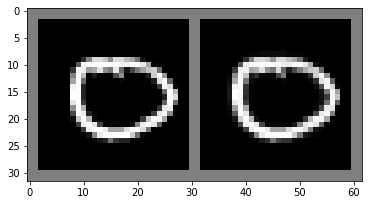

perc recon 1.0
num agree spots 784 784


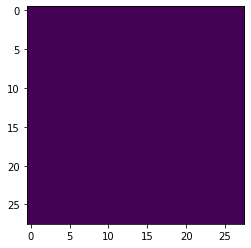

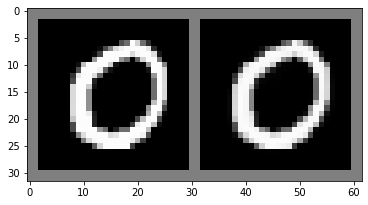

perc recon 1.0
num agree spots 784 784


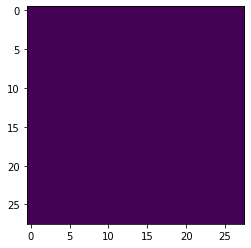

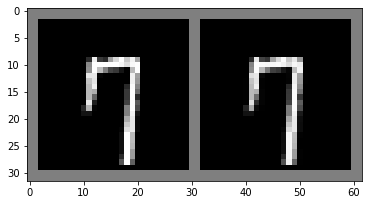

perc recon 0.9553571428571429
num agree spots 749 784


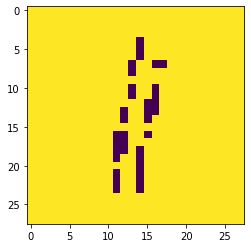

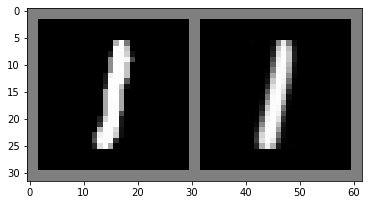

perc recon 1.0
num agree spots 784 784


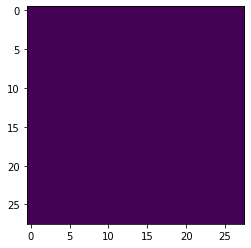

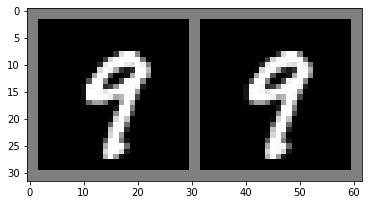

perc recon 0.9961734693877551
num agree spots 781 784


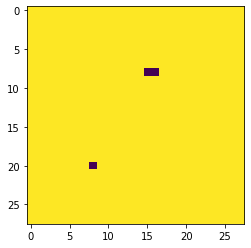

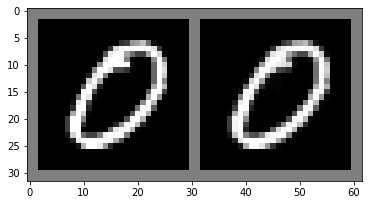

In [38]:
epsilon = 0.05
test_epsilon = 0.2 # debatable what this value should be. 
n_to_plot = 5
use_softmax=False
use_continuous = True
fix_perturb=False
check_for_closer_images = False
with torch.no_grad():
    for batch_ind, queries in enumerate(trainloader): 
        # get a minibatch
        bs = len(queries)
        print(queries.shape)
        queries = queries.to(device).T # making the queries into columns. 
        targets = torch.clone(queries)
        #project keys
        pKs = W_k@keys
        pKs = pKs/torch.norm(pKs, dim=0,keepdim=True)

        queries, isclosests, nsteps = convergence_loop(queries, norm_keys, keys)
        #print('nsteps', nsteps)
        # reconstruction loss after convergence iterations. 
        loss = ((queries - targets)**2).sum()

        perc_recon =  torch.logical_and(targets-test_epsilon < queries , 
                                 targets+test_epsilon > queries).sum(0).cpu().detach().numpy() / img_flat_len  

        agree_spots =torch.logical_and(targets-test_epsilon < queries , 
                                     targets+test_epsilon > queries).cpu().detach().numpy()

        for ind in range(bs):

            query, target, agree_spot = queries[:, ind].cpu().detach(), targets[:,ind].cpu().detach(), agree_spots[:,ind]

            plt.imshow(agree_spot.reshape(image_len,image_len))
            print( "perc recon", perc_recon[ind] )
            print( 'num agree spots', agree_spot.sum(), img_flat_len)
            plt.show()

            ct = torch.cat( [target.unsqueeze(0), query.unsqueeze(0)] )
            imshow(torchvision.utils.make_grid(ct.view(2, nchannels,image_len,image_len)))

            #imshow(target.detach().view(nchannels,image_len,image_len))
            #imshow(query.detach().view(nchannels,image_len,image_len))

            print("===========")
            if ind> n_to_plot:
                break
        break

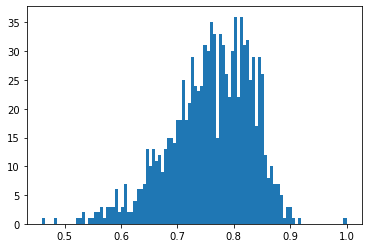

In [47]:
plt.hist((norm_keys@query/torch.norm(query)).detach().numpy(), bins=100)
plt.show()

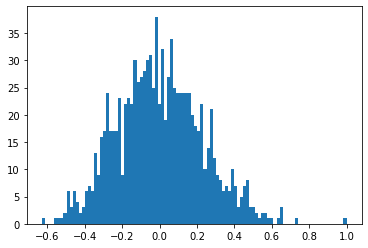

In [48]:

pQ = W_k@query
# L2 norm all
pQ = pQ/torch.norm(pQ)
# columnwise cosine similarities
dotp = pKs.T@pQ

plt.hist(dotp.detach().numpy(), bins=100)
plt.show()

In [49]:
tp=torch.cat((target.unsqueeze(0),query.unsqueeze(0)))

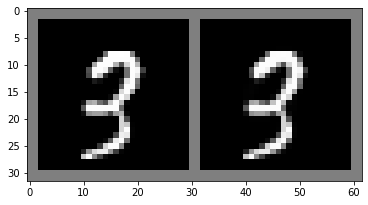

In [50]:
imshow(torchvision.utils.make_grid(tp.view(2, nchannels, image_len, image_len).detach() ))

In [51]:
((query - target)**2).sum()

tensor(0.0261, grad_fn=<SumBackward0>)

In [52]:
target.detach().view(nchannels,image_len, image_len);

In [53]:
query.detach().view(nchannels,image_len, image_len);

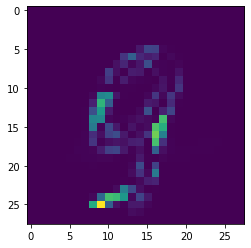

In [54]:
imshow(((query - target)**2).detach().view(nchannels,image_len, image_len))

In [27]:
torch.max(norm_keys@queries, dim=0)

torch.return_types.max(
values=tensor([0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449, 0.7449,
        0.7449, 0.7457, 0.7449, 0.7449]),
indices=tensor([33759, 49002,  2947,  1841, 42034, 12166, 57663, 31333, 22203, 43756,
        45599, 30029, 44815, 28322,  5055, 11904, 44425, 26443,  5319, 45482,
        23004, 14675, 55897, 36769, 10434, 46374,  2647, 49256, 30487, 16322,
        43495, 24735, 14097,  6621,  6352,  8941, 18521, 38965,  9210, 20521]))

# Validating the query perturbation is correct

In [12]:
dataiter = iter(trainloader)
queries = dataiter.next()
queries = queries.to(sdm_params.device).T
queries.shape

torch.Size([784, 128])

In [13]:
sdm_params.fix_perturb = True
sdm_params.perturb=50

pqueries, isclosests = perturb_queries(queries, sdm_params, norm_keys)
pqueries.shape

l2 norms: tensor([26.6033, 26.5587, 26.7031, 27.1756, 26.9116, 26.9285, 27.2286, 27.0989,
        26.9746, 26.8969, 27.0122, 26.8925, 27.1373, 27.1507, 26.9918, 27.1180,
        26.6385, 26.9599, 26.9506, 26.7526, 26.9597, 27.2367, 27.5535, 27.4280,
        27.1569, 26.5870, 26.8342, 27.0298, 27.3972, 26.5797, 27.3589, 26.8394,
        26.9233, 27.4841, 26.9941, 26.9099, 26.7630, 26.7443, 26.8877, 26.3261,
        27.4414, 26.2626, 26.6210, 27.1258, 26.9471, 27.4273, 26.5969, 27.0660,
        27.0710, 26.9594, 26.9244, 26.9969, 26.9266, 27.0832, 26.8616, 26.8727,
        27.4239, 26.9217, 27.1096, 27.4311, 26.9701, 26.1684, 27.0060, 27.5176,
        26.8542, 27.0570, 26.7126, 27.0778, 26.7733, 26.7887, 27.0301, 26.6988,
        26.9623, 26.8912, 26.7881, 26.8379, 26.9450, 27.3585, 26.8629, 26.9374,
        27.0542, 27.0802, 26.7487, 27.3769, 26.9637, 26.4888, 27.1183, 27.2284,
        26.8350, 26.7031, 27.0339, 27.4217, 27.4153, 26.8222, 26.8060, 26.3657,
        27.2428, 26.5484, 27.1

torch.Size([784, 128])

In [16]:
hamm_to_cosine(50,img_flat_len)

0.8724489795918368

In [18]:
(pqueries[:,0]/torch.norm(pqueries[:,0])).T @ (queries[:,0]/torch.norm(queries[:,0]))

tensor(0.8724, device='cuda:0')

In [19]:
pqueries[:,0].T@pqueries[:,0]

tensor(707.7343, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


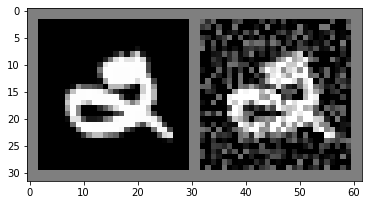

In [20]:
ct = torch.cat( [queries[:,0].cpu().unsqueeze(0), pqueries[:,0].cpu().unsqueeze(0)] )
imshow(torchvision.utils.make_grid(ct.view(2, nchannels,image_len,image_len)))
